In [10]:
from skimage.transform import resize
import SimpleITK as sitk
import cv2
import pydicom
import numpy as np
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 
from skimage.measure import label, regionprops, find_contours
from scipy.ndimage import map_coordinates
from skimage.morphology import remove_small_objects
from ipywidgets import interact, widgets
from IPython.display import Image , display, clear_output

In [11]:
def show_slice(img,r_slice=0):
    if r_slice == 0:
        r_slice = [np.random.randint(1,img.shape[i]) for i in [0,1,2]]
    plt.figure(figsize=(24,12))
    plt.subplot(1,3,1)
    plt.imshow(img[r_slice[0],:,:],cmap="gray")
    plt.title("xy")

    plt.subplot(1,3,2)
    plt.imshow(img[:,r_slice[1],:],cmap="gray")
    plt.title("xz")

    plt.subplot(1,3,3)
    plt.imshow(img[:,:,r_slice[2]],cmap="gray")
    plt.title("yz")
    
    plt.show()

def to_isotropic(sitk_img, target_spacing=[1,1,1]):

    # image = sitk.GetImageFromArray(dicom_array)
    # Create a new spacing and size for the resampled image
    new_spacing = target_spacing
    new_size = [int(sz * spc / new_spc) for sz, spc, new_spc in zip(sitk_img.GetSize(), sitk_img.GetSpacing(), new_spacing)]
    # Resample the image to the new spacing and size
    resampled_image = sitk.Resample(sitk_img, new_size, sitk.Transform(), sitk.sitkBSpline, sitk_img.GetOrigin(), new_spacing)
    # dicom_array_resampled = sitk.GetArrayFromImage(resampled_image)
    
    return resampled_image

def read_dcm (path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(path)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image_np = sitk.GetArrayFromImage(image)
    return image_np, image

In [12]:
analysis_dict={
    1:{"range":[0,10], "f_e":1178e-7, "v_v":5.24e7, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0},
    3:{"range":[21,30], "f_e":4320e-7, "v_v":1.41e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    4:{"range":[31,40], "f_e":5890e-7, "v_v":3.35e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    5:{"range":[41,50], "f_e":7461e-7, "v_v":6.54e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0},
    6:{"range":[51,60], "f_e":9032e-7, "v_v":1.13e4, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    2:{"range":[11,20], "f_e":2749e-7, "v_v":4.19e4, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    7:{"range":[61,80], "f_e":22780e-7, "v_v":2.68e4, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    8:{"range":[81,100], "f_e":29060e-7, "v_v":5.24e4, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    9:{"range":[101,120], "f_e":35340e-7, "v_v":9.05e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    10:{"range":[121,140], "f_e":41630e-7, "v_v":1.44e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0},
    11:{"range":[141,160], "f_e":47910e-7, "v_v":2.14e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    12:{"range":[161,180], "f_e":54190e-7, "v_v":3.05e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    13:{"range":[181,200], "f_e":60476e-7, "v_v":4.19e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    14:{"range":[201,220], "f_e":66760e-7, "v_v":5.58e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    15:{"range":[221,240], "f_e":73040e-7, "v_v":7.24e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0},
    16:{"range":[241,260], "f_e":79330e-7, "v_v":9.20e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    17:{"range":[261,280], "f_e":85610e-7, "v_v":1.15e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    18:{"range":[281,300], "f_e":91890e-7, "v_v":1.41e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    19:{"range":[301,350], "f_e":257200e-7, "v_v":2.24e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    20:{"range":[351,400], "f_e":296500e-7, "v_v":3.35e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0},
    21:{"range":[401,450], "f_e":335800e-7, "v_v":4.77e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    22:{"range":[451,500], "f_e":375000e-7, "v_v":6.54e3, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    23:{"range":[501,1000], "f_e":5910000e-7, "v_v":5.24e1, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    24:{"range":[1001,1500], "f_e":9837000e-7, "v_v":1.77, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    25:{"range":[1501,2000], "f_e":13760000e-7, "v_v":4.19, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0},
    26:{"range":[2001,2500], "f_e":17690000e-7, "v_v":8.18, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    27:{"range":[2501,3000], "f_e":21620000e-7, "v_v":1.41e-1, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}, 
    28:{"range":[3001,4000], "f_e":55020000e-7, "v_v":3.35e-1, "count":0, "freq":0.0, "p_total":0, "void_in_class":0, "air_content":0.0, "c_air_content":0.0}
}
ranges = [analysis_dict[i]["range"] for i in range(1,29)]
print(ranges)

[[0, 10], [11, 20], [21, 30], [31, 40], [41, 50], [51, 60], [61, 80], [81, 100], [101, 120], [121, 140], [141, 160], [161, 180], [181, 200], [201, 220], [221, 240], [241, 260], [261, 280], [281, 300], [301, 350], [351, 400], [401, 450], [451, 500], [501, 1000], [1001, 1500], [1501, 2000], [2001, 2500], [2501, 3000], [3001, 4000]]


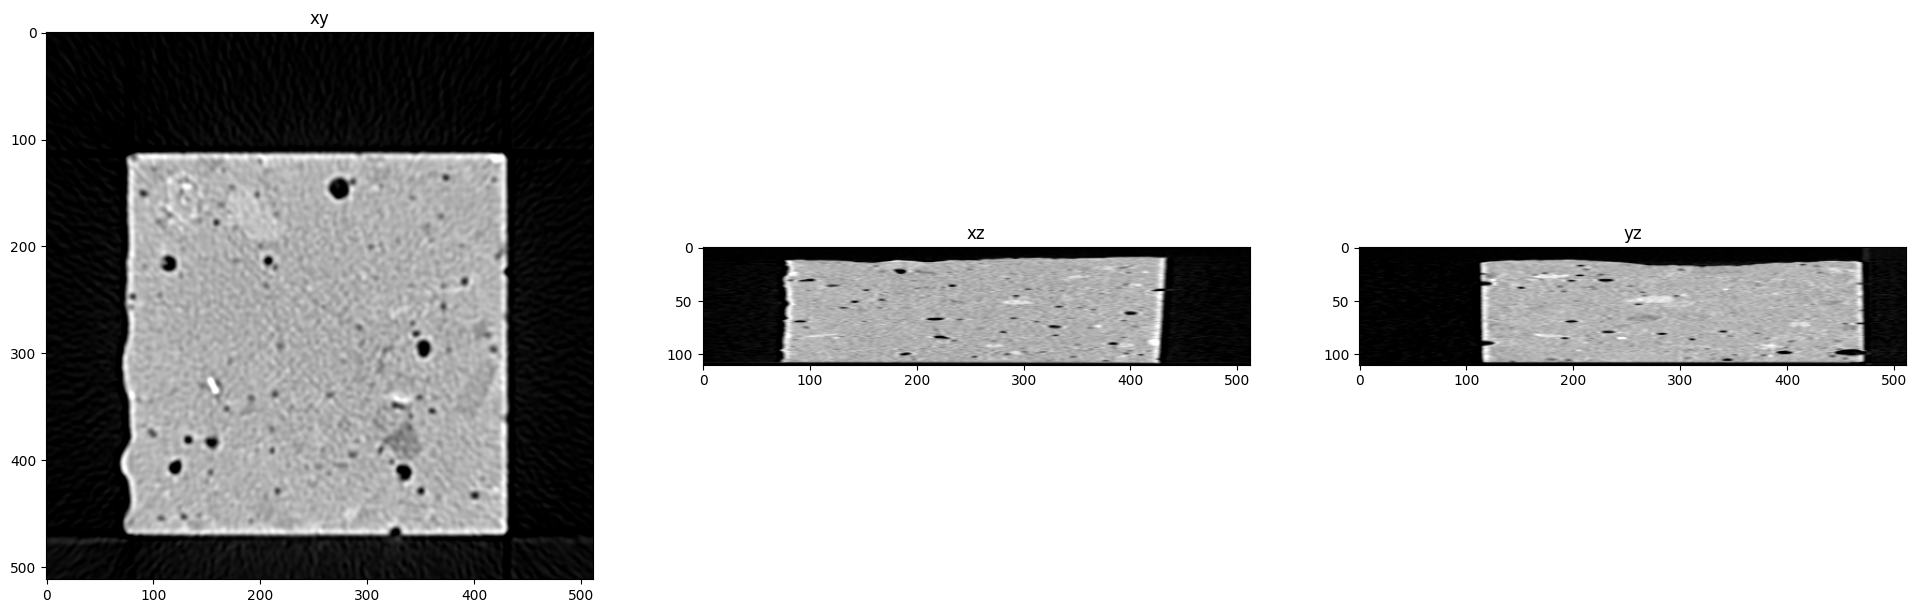

In [14]:
path = os.path.join(os.getcwd(),"Sample_Data")
image_np, image = read_dcm(path)

show_slice(image_np)


Image Size:  (1000, 1000, 1320)
Pixel Spacing:  (0.1, 0.1, 0.1)
Image Origin:  (-51.90234375, -168.90234375, -109.3)


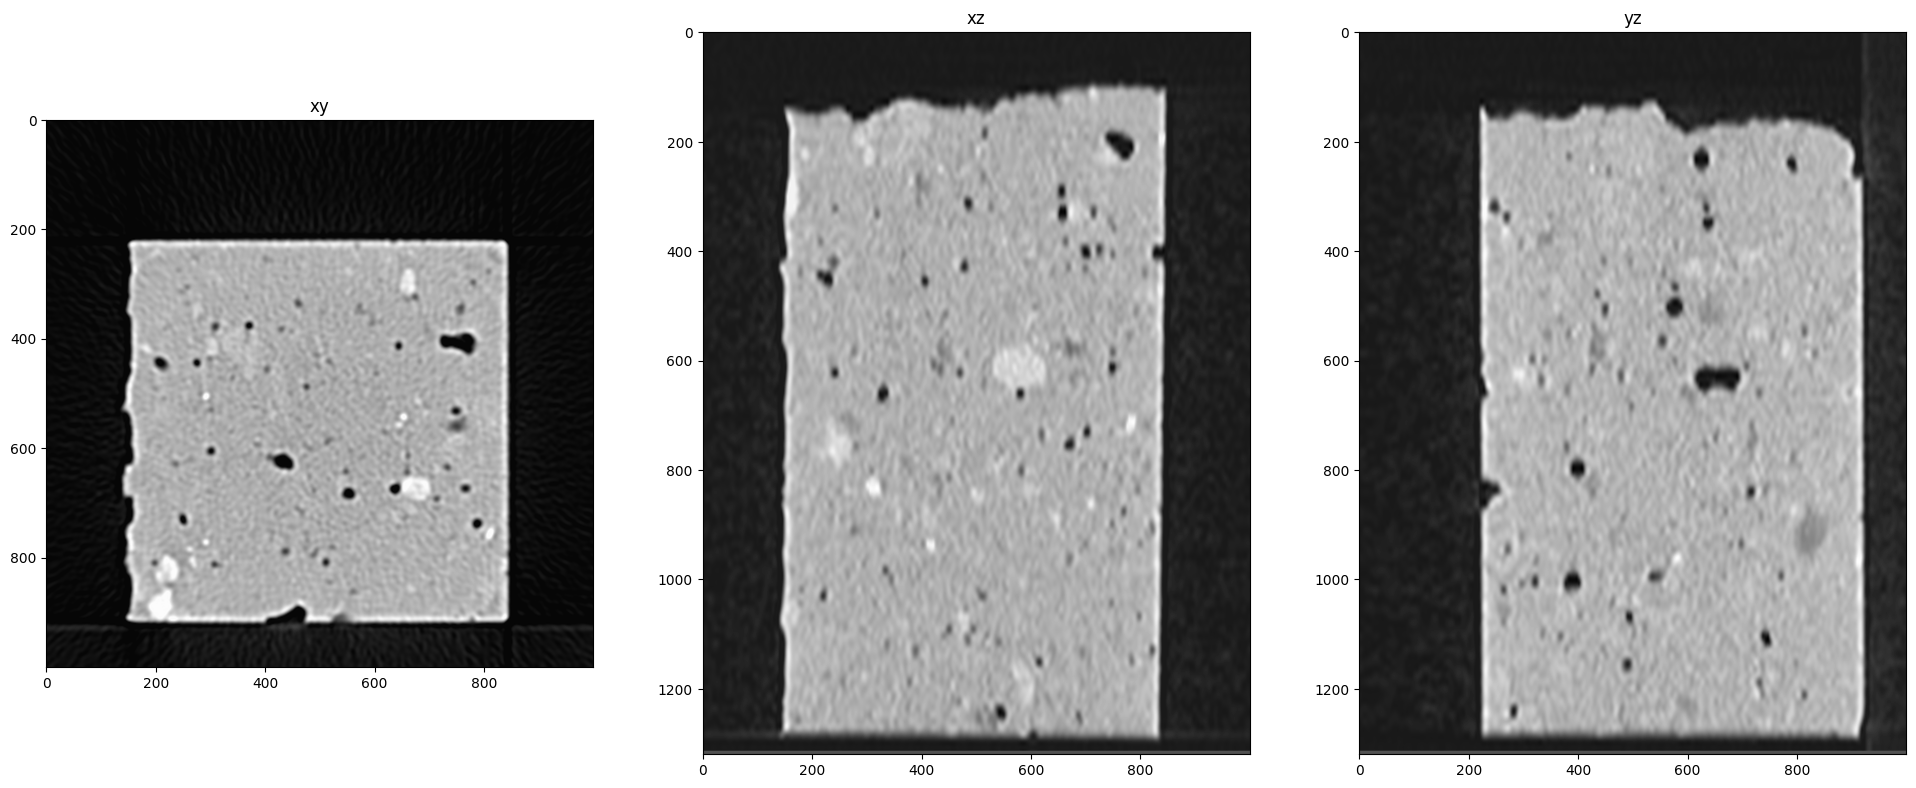

In [15]:
image = to_isotropic(image,[0.1,0.1,0.1])
print("Image Size: ",image.GetSize())
print("Pixel Spacing: ",image.GetSpacing())
print("Image Origin: ",image.GetOrigin())
spacing = image.GetSpacing()

show_slice(sitk.GetArrayFromImage(image))

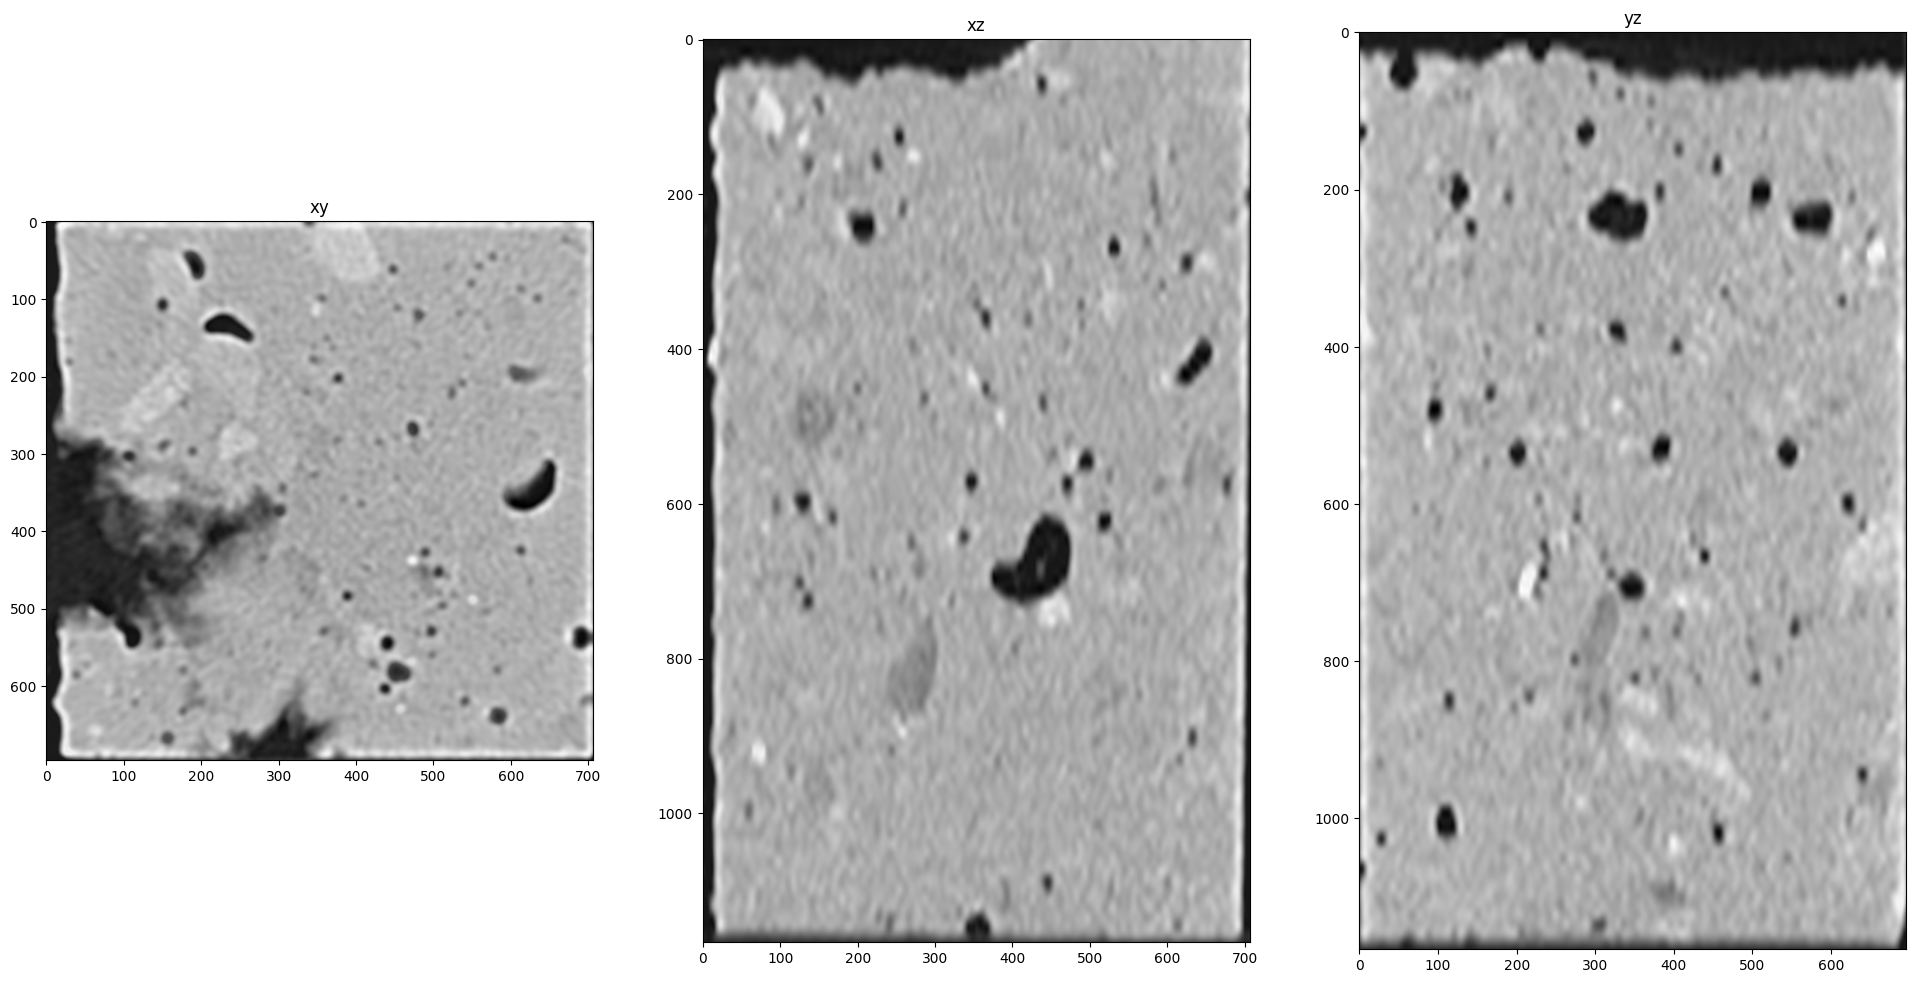

In [16]:
image_np = sitk.GetArrayFromImage(image)
binary_mask = (image_np>0).astype(np.uint8)
labeled_mask = label(binary_mask)
regions = regionprops(labeled_mask)
max_region = max(regions,key=lambda region: region.area)
min_slice, min_row, min_col, max_slice, max_row, max_col = max_region.bbox
cropped = image_np[min_slice+100:max_slice-5,min_row+6:max_row-5,min_col+6:max_col-5]
show_slice(cropped)

Image Size:  (1052, 685, 685)


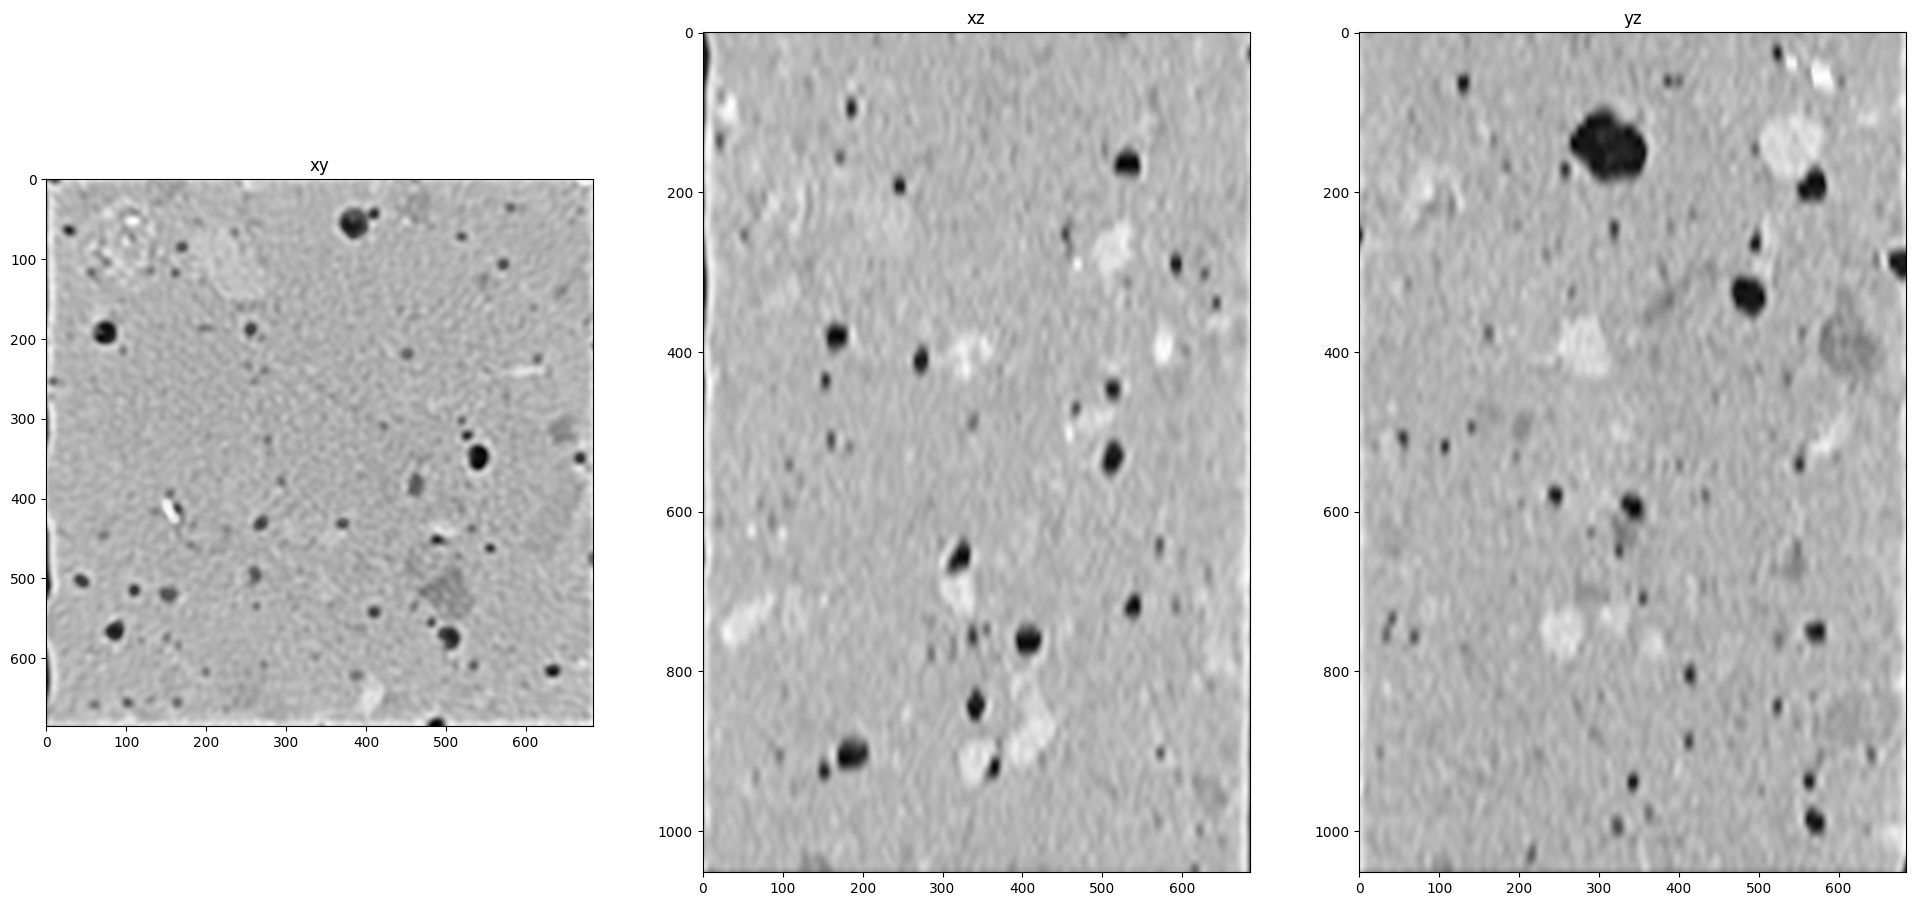

In [17]:
# Experimental Cropping coordinates
cropped = image_np[min_slice+200:max_slice-20,min_row+12:max_row-10,min_col+18:max_col-15]
print("Image Size: ",cropped.shape)
show_slice(cropped)


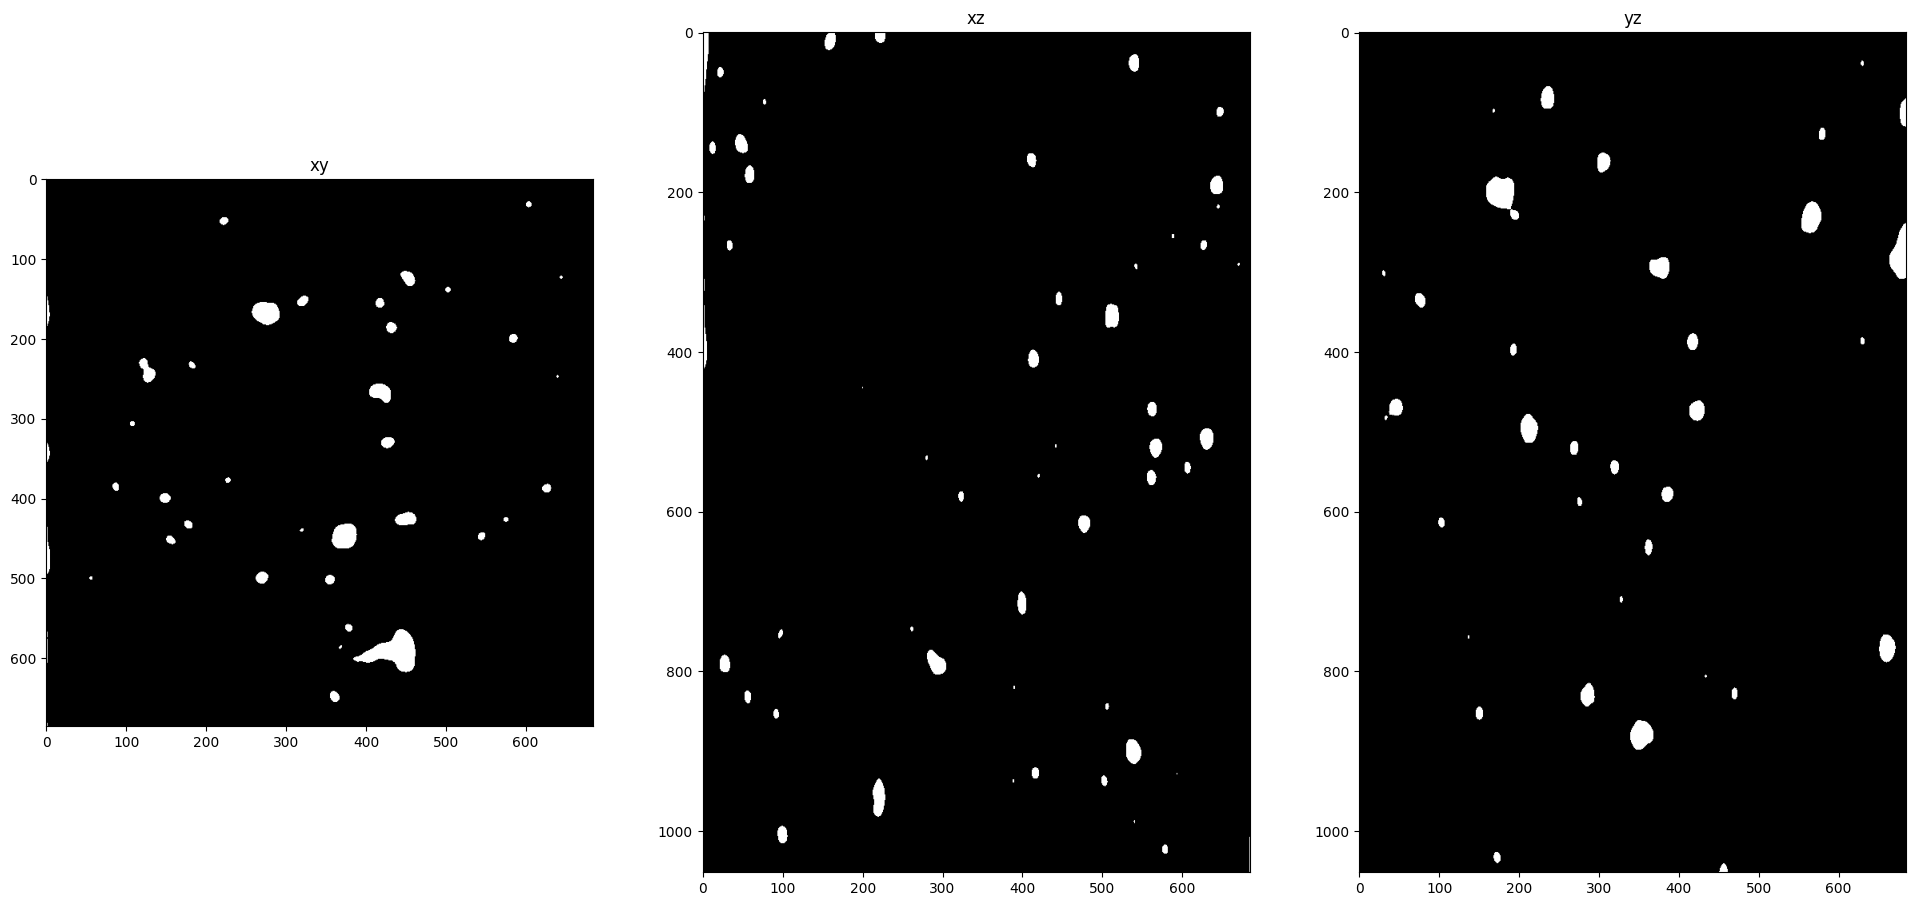

Number of holes: 1265


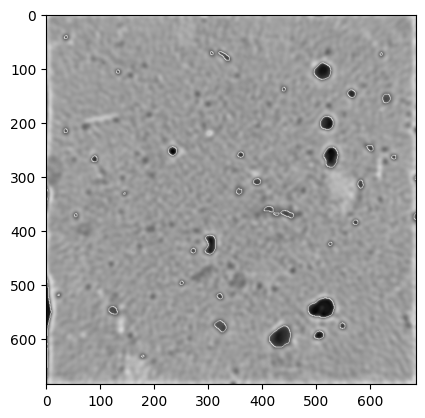

In [18]:
max_vol_mm = 100
max_vol_vox = max_vol_mm//image.GetSpacing()[0]
# print(max_vol_vox)
hole_mask = (cropped < 600).astype(np.uint8)
labeled_holes, num_holes = label(hole_mask, return_num=True)
regions = regionprops(labeled_holes)
labeled_holes_filtered = []
vols = [regions[i].area_filled for i in range(labeled_holes.max())]  
holes = [vol for vol in vols if vol < max_vol_vox]
num_holes = len(holes)
# print(regions[0].centroid)
show_slice(hole_mask)
# Count the circular holes 
print(f"Number of holes: {num_holes}")
# print(labeled_holes[:5])

# Find and store contours in 2D slices
contours_2d = []
for z in range(labeled_holes.shape[0]):
    contour = find_contours(labeled_holes[z], level=0.5)
    contours_2d.append(contour)

# Create a copy of the cropped volume for drawing contours
cropped_with_contours = np.copy(cropped)

# Project the 2D contours into 3D space
for z, contours in enumerate(contours_2d):
    for contour in contours:
        for coords in contour:
            y, x = coords  # Coordinates are in (y, x) order in 2D
            cropped_with_contours[z, int(y), int(x)] = 4000  # Set contour pixels to 255 (white)

# Display or save the image as needed
# (You can replace this with your preferred method)
# Example: Display a slice of the volume with contours
slice_index = cropped_with_contours.shape[0] // 2  # Choose a central slice
plt.imshow(cropped_with_contours[slice_index], cmap='gray')
plt.show()

In [19]:
print(f" Total Volume of the cement paste: {int((np.sum((cropped > 600).astype(np.uint8),axis=None)*(0.1)**3))} mm")
print(f" Total Volume of the sample: {int(cropped.shape[0]*cropped.shape[1]*cropped.shape[2]*(0.1)**3)} mm")

 Total Volume of the cement paste: 485480 mm
 Total Volume of the sample: 493624 mm


In [9]:
def visualize_axial_plane(z):
    plt.figure(figsize=(6, 6))
    plt.imshow(cropped_with_contours[z, :, :], cmap='gray')
    plt.title(f"Axial Plane at z = {z}")
    plt.axis('off')
    plt.show()

max_z = cropped_with_contours.shape[0] - 1
slider = widgets.IntSlider(value=0, min=0, max=max_z, step=1, description='Z Index')
interact(visualize_axial_plane, z=slider)

# Display the slider
display(slider)

interactive(children=(IntSlider(value=0, description='Z Index', max=1051), Output()), _dom_classes=('widget-in…

IntSlider(value=0, description='Z Index', max=1051)

In [24]:
def line_to_dsf(line,spacing=0.1):
    lengths_dict = {"void":[] , "solid":[]}
    counter = 1
    indicator = line[0]
    for i in range(1,len(line)):
        if indicator == line[i]:
            counter +=1
        else:
            if indicator == 1:
                lengths_dict["void"].append(round(counter*spacing,ndigits=1))
            else:
                lengths_dict["solid"].append(round(counter*spacing,ndigits=1))
        
            counter = 1
            indicator = line[i]
    if indicator == 1:
        lengths_dict["void"].append(round(counter*spacing,ndigits=1))
    else:
        lengths_dict["solid"].append(round(counter*spacing,ndigits=1))
    return lengths_dict


def chord_to_class(void_list, constants_dict,spacing=0.1):
    classes = {}
    ranges = [constants_dict[i]["range"] for i in range(1,29)]
    voids_mm = [e*1000 for e in void_list]
    for void in voids_mm:
        index = len(ranges)//2
        flag = True
        while(flag):
            if void > ranges[index][1]:
                index += 1
                
                if index == len(ranges):
                    if index not in classes.keys():
                        classes[index] = 1
                    else:
                        classes[index] += 1
                    flag = False
                
            elif void < ranges[index][0]:
                index -= 1
            else:
                if index+1 not in classes.keys():
                    classes[index+1] = 1
                else:
                    classes[index+1] += 1
                flag = False
    return classes


def lengths_to_TsTa(lengths_list):
    Ta = 0
    Ts = 0
    for length in lengths_list:
        Ta += sum(length["void"])
        Ts += sum(length["solid"])
    return Ts, Ta

#Sample test for the function
print(".........................\n Testing line to distance factor function ")
l = [[1, 1, 1, 1, 0, 0, 0, 1, 1],[1, 1, 1, 0, 0, 0],[1,0,0,1,1,1,1,0]] 
for line in l:
    print(line)
    print(line_to_dsf(line))

print(".........................\n Testing chord to class function")
voids = [1,10,2.2,1,1.6] 
print(voids)
print(chord_to_class(voids,analysis_dict))

print(".........................\n Length to Ts Ta function")

print(lengths_to_TsTa([{'void': [0.4], 'solid': [0.2, 0.1]},
                                   {'void': [], 'solid': [0.2, 0.1,0.4]},
                                   {'void': [0.1, 0.4,0.5], 'solid': [0.1]}]))


.........................
 Testing line to distance factor function 
[1, 1, 1, 1, 0, 0, 0, 1, 1]
{'void': [0.4, 0.2], 'solid': [0.3]}
[1, 1, 1, 0, 0, 0]
{'void': [0.3], 'solid': [0.3]}
[1, 0, 0, 1, 1, 1, 1, 0]
{'void': [0.1, 0.4], 'solid': [0.2, 0.1]}
.........................
 Testing chord to class function
[1, 10, 2.2, 1, 1.6]
{23: 2, 28: 1, 26: 1, 25: 1}
.........................
 Length to Ts Ta function
(1.1, 1.4)


In [40]:
def air_void_dist_analysis(vol):

    lengths_list = []
    counts_list = []
    spacing = 0.1
    # dsf_dict = {"dsf_x":[],"dsf_y":[],"dsf_z":[]}
    # print("\n .....Starting of the process.... \n")
    step_mm = 6
    step_vox = int(step_mm/spacing) 
    slices =  [range(0,cropped.shape[i],step_vox) for i in range(3)]
    #Loop through the z slices 
    print(".....Starting of analysis, Y and X axes.... \n")

    for slice in slices[0]:

        #Taking sample slice
        sample_slice = vol[slice,:,:] 
        #Getting the mask 
        hole_mask = (sample_slice < 600).astype(np.uint8)
        #sampling along x
            
        #print("\n .....Starting of the analysis, X axis.... \n")
        for line in slices[1]:

            sample_line = hole_mask[line,:].flatten().tolist()

            lengths_dict = line_to_dsf(sample_line)
            counts_dict = chord_to_class(lengths_dict["void"],analysis_dict)

            lengths_list.append(lengths_dict)
            counts_list.append(counts_dict)

    return lengths_list , counts_list
            
            # dsf_dict["dsf_x"].append(list(map(lambda x : round(x*spacing,ndigits=3) ,line_to_dsf(line_sample_2(hole_mask,coords=coords,axis=0)))))

#Running for the given volume
lengths_list, counts_list = air_void_dist_analysis(cropped)

# Paste content by volume calculated from the mix proportions
P = 0.0
# Total length of traverse across solid phases
Ts = 0.0
# Total length of traverse across air voids
Ta = 0.0
# Total Transverse Length
Ttot = 0.0
# Total Air Content
A = 0.0 #Ta/Ttot *100
# Total number of chords
N = 0
# Specific Surface of Air
alpha = 0.0 # 4*N/Ta
# Paste:Air Ratio
R = 0.0 # P/A
#Spacing Factor
L = 0.0 # (3*(1.4*((1+R)**(1/3))-1)) / alpha or P*Ttot/400*N



solid_vol = int((np.sum((cropped > 600).astype(np.uint8),axis=None)*(0.1)**3))
tot_vol = int(cropped.shape[0]*cropped.shape[1]*cropped.shape[2]*(0.1)**3)
P = solid_vol/tot_vol
 
print(lengths_list)
print(counts_list)

Ts , Ta = lengths_to_TsTa(lengths_list=lengths_list)

Classes_dict = dict()
for dic in counts_list:
    for key,item in dic.items():
        if key not in Classes_dict.keys():
            Classes_dict[key] = item
        else:
            Classes_dict[key] += item

for key in Classes_dict.keys():
    N += Classes_dict[key]

print(Classes_dict)
Ttot = Ts + Ta

A = Ta*100/Ttot

alpha = 4*N/Ta

R = P/A

L = (P*Ttot) / (400*N)


print(f"Total Volume of the cement paste: {solid_vol} mm")
print(f"Total Volume of the sample: {tot_vol} mm")
print(f"Paste content by volume P: {P}")
print(f"Total length of traverse across solid phases Ts: {Ts} mm")
print(f"Total length of traverse across air voids Ta: {Ta} mm")
print(f"Total Transverse Length Ttot: {Ttot} mm")
print(f"Total Air Content A: {A} %")
print(f"Total number of chords N: {N}")
print(f"Specific Surface of Air alpha: {alpha} mm^-1")
print(f"Paste:Air Ratio R: {R}")
print(f"Spacing Factor L: {L} mm")


# df.head()
# for key,value in dsf_dict.items():
#     print(f"sample data from {key}")
#     print(value[:3])
#     print("..........................")  

.....Starting of analysis, Y and X axes.... 

[{'void': [0.2], 'solid': [68.3]}, {'void': [0.4], 'solid': [68.1]}, {'void': [], 'solid': [68.5]}, {'void': [0.7, 0.9, 6.5], 'solid': [48.3, 7.2, 4.9]}, {'void': [0.3], 'solid': [68.2]}, {'void': [0.3, 1.6], 'solid': [15.1, 43.7, 7.8]}, {'void': [0.6], 'solid': [67.9]}, {'void': [], 'solid': [68.5]}, {'void': [1.0], 'solid': [67.5]}, {'void': [], 'solid': [68.5]}, {'void': [0.5], 'solid': [68.0]}, {'void': [0.5, 1.4], 'solid': [29.9, 36.7]}, {'void': [2.2], 'solid': [53.0, 13.3]}, {'void': [0.3], 'solid': [68.2]}, {'void': [0.1], 'solid': [68.4]}, {'void': [0.5], 'solid': [68.0]}, {'void': [], 'solid': [68.5]}, {'void': [0.8], 'solid': [67.6, 0.1]}, {'void': [0.1], 'solid': [68.4]}, {'void': [1.0, 0.7], 'solid': [35.8, 7.2, 23.8]}, {'void': [0.9], 'solid': [67.6]}, {'void': [0.3], 'solid': [47.0, 21.2]}, {'void': [0.4, 1.9, 1.2], 'solid': [11.0, 7.4, 46.6]}, {'void': [0.4, 0.3], 'solid': [67.4, 0.4]}, {'void': [3.2], 'solid': [56.0, 9.3]},

In [16]:
print(type(labeled_holes))
print(labeled_holes.shape)

<class 'numpy.ndarray'>
(1052, 685, 685)
